In [1]:
'''Figure 2: Causality Analysis
1.	Distribution of CAVIAR scores (let’s see how it looks) 
2.	Example “causal loci”. Color dots by genotype of best SNP 
1.	Multi-allelic example from ASHG poster 
2.	CSTB example 
3.	One “negative” example of eSTR with good p-value but poor CAVIAR score 
3.	Enrichment as a function of distance to TSS, TES, nearest splice site  
4.	Enrichment by motif 
'''

# Libraries

import os
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.api as sm
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Path to data
RESDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
DATA =  RESDIR+"SUMMARY/Merged_Causality_best_tissue.table"
BASEDIR = "/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/"
SNPS = "/storage/szfeupe/Runs/GTEx_estr/SNP_Analysis"
STRS = "/storage/szfeupe/Runs/GTEx_estr/Normalized_Genotypes/"
COLOR = ['b', 'r', 'g', 'k', 'y', 'm', 'grey']


# Output path
OUTPATH = "pdfs"
PREFIX = "Figure2" # Keep as a variable in case we move things around!

COLORS = {
    "WholeBlood": "m","Cells-Transformedfibroblasts": "skyblue",
    "Muscle-Skeletal": "mediumslateblue",
    "Artery-Tibial": "red", "Adipose-Subcutaneous": "orange",
    "Lung": "greenyellow","Esophagus-Mucosa": "burlywood"
}
SHORTEN = {
    "WholeBlood": "Blood","Cells-Transformedfibroblasts": "Fibr.",
    "Muscle-Skeletal": "Muscle","Artery-Tibial": "Artery",
    "Adipose-Subcutaneous": "Adipose","Lung": "Lung",
    "Esophagus-Mucosa": "Esophagus", "LCL": "LCL"
}
TISSUES = [item for item in list(COLORS.keys()) if item != "permuted"]

CHRS=[x for x in range(2,23)]+['X', 'Y']

#--
def plotthat(Frame, BASEDIR):
    chs = list(Frame['chrom'])[0]
    gene = list(Frame['gene'])[0]
    start = list(Frame['best.str.start'])[0]
    tissue = list(Frame['best.tissue'])[0]
    score = list(Frame['best.score'])[0]
    
    snps=pd.read_csv(BASEDIR+tissue+"/SNP_Analysis/PQValues.txt", sep="\t",low_memory=False)
    expr = pd.read_csv(BASEDIR+tissue+"/Corr_Expr.csv",sep=',' ,low_memory=False) 
    snp =pd.read_csv(SNPS+"/SNP_raw_gt_"+chs, sep='\t',low_memory=False) #snps
    Genos=pd.read_csv(STRS+"STR_Raw_Gen."+chs, sep='\t',low_memory=False)
    #gene name
    S = snps.loc[snps['gene']==gene]['str.start']; S=int(S)
    Gene = Gene_table.loc[Gene_table['gene']==gene]['gene.name'].values[0]
    print('\n----->',chs,' gene ',gene,'(',Gene,')  Causality Score: ',score,'\nCounts by SNP genotypes')
    
    #restrict to samples
    samples = list(expr.index)
    Genosnp = snp.loc[snp['start']==S,samples]
    Genostr = Genos.loc[Genos['start']==start, samples]
    Genosnp = Genosnp.replace('None', np.nan) ; #print(Genosnp)
    Genostr = Genostr.replace('None', np.nan) ; #print(Genostr)
    #Expression
    Expr = expr[gene]
    
    #Figure    (1) STR vs EXPR
    plt.figure(1, figsize=(15,3))
    plt.subplot(131)
    plt.title(tissue+' tissue')
    plt.scatter(Genosnp, Expr, label='Lead SNP', color='b',marker='.')
    plt.ylabel(Gene+' expression')
    plt.xlabel('Best SNP genotypes')
    plt.subplot(132)
    plt.scatter(Genostr, Expr,label='eSTR', color='g',marker='.')
    #plt.ylabel(Gene+' Gene expression')
    plt.xlabel('eSTR genotypes \nSTR_'+str(int(start)))

    #Figure (2) Hold snp genotypes constant
    geno=list(set(Genosnp.values.tolist()[0]))
    geno=list(set([x for x in np.nan_to_num(geno) if x!='nan']))
    n=len(geno) ; N=0
    ind=Genosnp.index[0]
    plt.subplot(133) #####################################################################
    ax = plt.gca()   #fig.add_subplot(133)
    SET=[]
    for i in range(n):      #****************
        S = Genosnp.T.loc[Genosnp.T[ind]==geno[i]]
        sample=list(S.index)
        S['Exp']=Expr.loc[sample]
        S['Str']=Genostr.T.loc[sample][Genostr.index[0]]
        #print(N, list(S['Str']))
        S['Str'] = S['Str'].astype(float)
        S['Str']+=N
        if len(S['Exp'])==0:
            continue
        print(geno[i], S.shape) #**************************************
        S['label']=[i]*S.shape[0]
        SET.append(S)
    data = pd.concat(SET)
    data['Y']=[i for i in range(1,data.shape[0]+1,1)]
    data=data.groupby(('label'))
   
    x_labels = []
    x_labels_pos = []; N=0; col=[]
    for num, (name, group) in enumerate(data):
        #print(num, name, group)
        group['Str']+=N
        group.plot(kind='scatter', x='Str', y='Exp',color=COLOR[num], ax=ax, marker='.', s=6)
        x_labels.append(name)
        col.append(COLOR[num])
        x_labels_pos.append((group['Str'].iloc[-1] - (group['Str'].iloc[-1] - group['Str'].iloc[0])/2))
        N=N+max(group['Str'].abs())+25
        ax.set_xticks(x_labels_pos)
        ax.set_xticklabels(x_labels) 
        for xtick, color in zip(ax.get_xticklabels(), col):
            xtick.set_color(color)

        
    plt.ylabel('')    
    plt.xlabel('STR_'+str(int(start))+' at \n SNPs genotypes')
#plt.axis('off')
    plt.show()
#END    


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


WholeBlood (89, 8) 767 (767, 10) 767


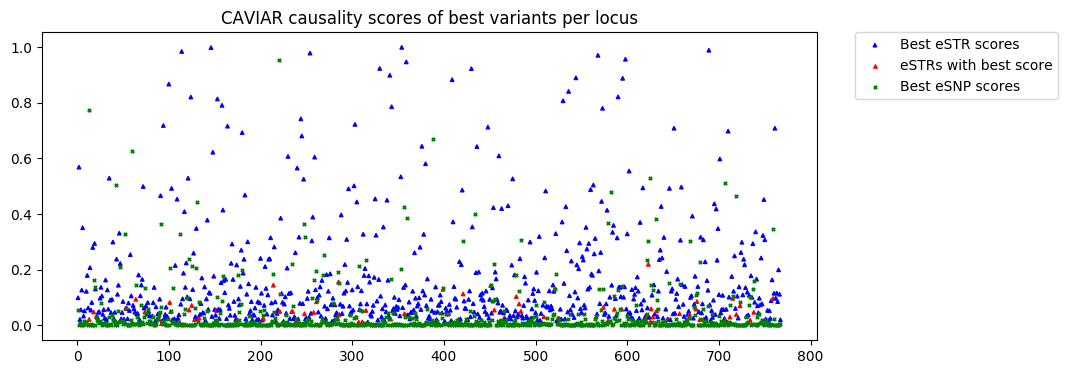

In [2]:
#1.Distribution of CAVIAR scores (let’s see how it looks) 

#Add eSTRs label
ESTRs = pd.read_csv(os.path.join(RESDIR,'SUMMARY/LR_SummaryTest_Table.tsv'), sep='\t',low_memory=False)
ESTRs['best.str.start']=ESTRs['str.start']
ESTRs = ESTRs[['chrom','best.str.start','gene','eSTR_In_tissues']] 

#Caviar results
Caviar_Results = {} # Map of tissue -> data
for T in TISSUES:
    Frames=[]
    for i in CHRS:
        data = pd.read_csv(os.path.join(RESDIR, T, "HH/caviar.out"+str(i)), sep="\t")
        Frames.append(data)
    Caviar_Results[T]=pd.concat(Frames).merge(ESTRs, on=['gene', 'chrom','best.str.start'])
    Caviar_Results[T]['SNP']=[1 if x[:3]=='SNP' else 0 for x in list(Caviar_Results[T]['top.variant'])]

#In tissue T
for T in TISSUES:
    Table = Caviar_Results[T].loc[Caviar_Results[T]['eSTR_In_tissues']>=1]    
    BS = Table.loc[Table['SNP']==0] 

    SS=[]
    TS=[]
    for gene in list(Table['gene']):
        if gene not in list(BS['gene']):
            snpscore=list(Table.loc[Table['gene']==gene]['top.variant.score'])[0]
            topsnp = list(Table.loc[Table['gene']==gene]['top.variant'])[0]
            SS.append(snpscore); TS.append(topsnp)
            continue
        else:
            genedir=os.path.join(RESDIR, T, "HH/caviar_temps/")+gene+"/caviar_post"
            post = pd.read_csv(genedir, sep="\t", header=None)
            if len(post.sort_values(post.columns[2], ascending=False).values)<=1:
                snpscore=0; topsnp='na'
            else:
                snpscore  =  post.sort_values(post.columns[2], ascending=False).values[1][2]
                topsnp  =  post.sort_values(post.columns[2], ascending=False).values[1][0]
        SS.append(snpscore)
        TS.append(topsnp)            
    Table['top.snp']=TS     ; Table['top.snp.score']=SS
    print(T, BS.shape, len(TS), Table.shape, len(SS)) 

    X = Table.loc[:,'best.str.score']      #STRs
    Y = Table.loc[:,'top.snp.score']       #SNPs
    color=list(np.where(X>Y,'r','b'))

    df=pd.DataFrame({'SNP':X, 'STR':Y, 'COL':color})
    w = [i for i in range(1,df.shape[0]+1,1)]

    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    ax.set_title("CAVIAR causality scores of best variants per locus")
    ax.scatter(w,df['STR'], color=list(df['COL']), label='Best eSTR scores', s=6, marker='^')
    ax.scatter([], [], marker='^', color='r', label="eSTRs with best score", s=6)
    ax.scatter(w,df['SNP'], color='g', label='Best eSNP scores', s=5, marker='x')
    ax.legend(loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    break
plt.show()

#fig.savefig(os.path.join(OUTPATH, "%sDistribution.png"%PREFIX))

In [18]:
# Example “causal loci”. Color dots by genotype of best SNP 
    for i in range(n):
        S = Genosnp.T.loc[Genosnp.T[ind]==geno[i]]
        sample=list(S.index)
        S['Exp']=Expr.loc[sample]
        S['Str']=Genostr.T.loc[sample][Genostr.index[0]]
        #print(N, list(S['Str']))
        S['Str'] = S['Str'].astype(float)
        S['Str']+=N
        if len(S['Exp'])==0:
            continue
        print(geno[i], S.shape)
        plt.scatter(list(S['Str']), list(S['Exp']), color=COLOR[i], marker='.',s=5)
        plt.axvline(x=N, linewidth=1, color='lightblue')
#        plt.title.set_text(Gene+' Expression @ SNP_genotype='+str(geno[i])+' ( n='+str(len(S['Exp']))+' )')
        if max(list(S['Str'].values))-min(list(S['Str'].values))!=0:
            N += max(list(S['Str'].values))-min(list(S['Str'].values))+25
        else:
            N +=max(list(S['Str'].values))+25

Relevent examples

-----> chr21  gene  ENSG00000160213.5 ( CSTB )  Causality Score:  0.941574476131 
Counts by SNP genotypes
2 (6, 3)
1 (47, 3)
0 (74, 3)


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


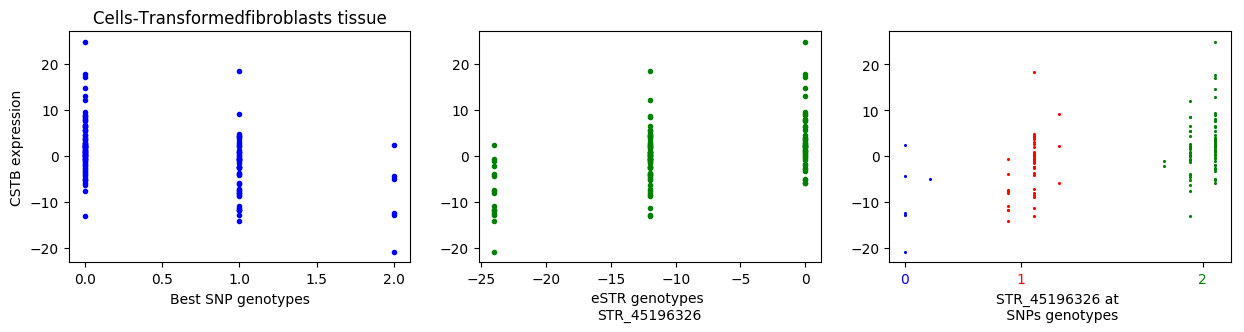


-----> chr14  gene  ENSG00000100852.8 ( ARHGAP5 )  Causality Score:  0.914728681435 
Counts by SNP genotypes
2 (74, 3)
1 (23, 3)
0 (4, 3)


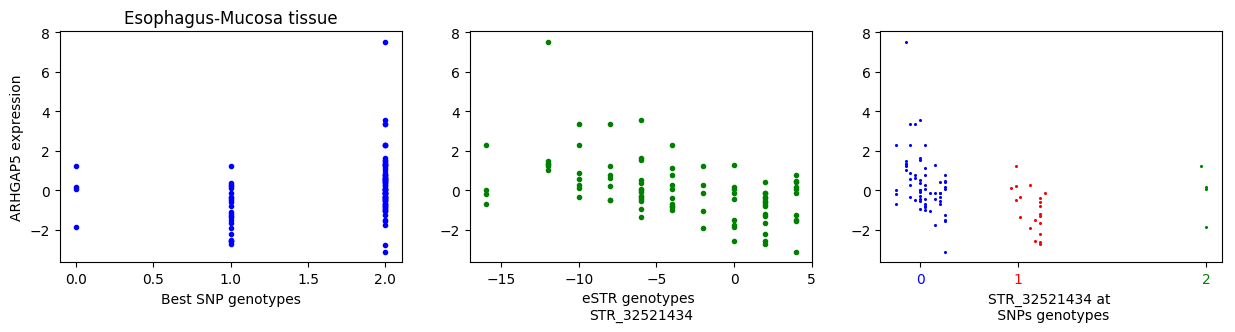


-----> chr16  gene  ENSG00000090857.9 ( PDPR )  Causality Score:  0.772611540101 
Counts by SNP genotypes
1 (82, 3)
0 (25, 3)


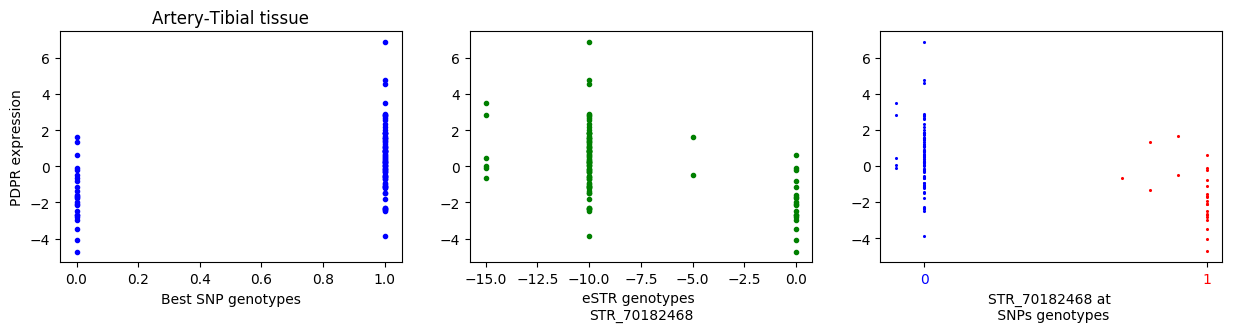

In [3]:
Gene_table = pd.read_csv('/storage/szfeupe/Runs/GTEx_estr/FEATURES/Genes_only_table', sep='\t')
Data = pd.read_csv(DATA, sep='\t')
data = Data.sort_values('best.score', ascending=[False])
data0 = data.head(20)
#
#Relevent Examples from poster 
#
print('Relevent examples')
examples = ['ENSG00000160213.5', 'ENSG00000100852.8', 'ENSG00000090857.9']

for G in examples:
    data = Data.loc[Data['gene']==G]
    plotthat(data, BASEDIR)
    



Examples of Causal loci (eSTRs with high causality score)

-----> chr10  gene  ENSG00000198035.9 ( AGAP9 )  Causality Score:  0.99097632782 
Counts by SNP genotypes
2 (4, 3)
1 (36, 3)
0 (61, 3)


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


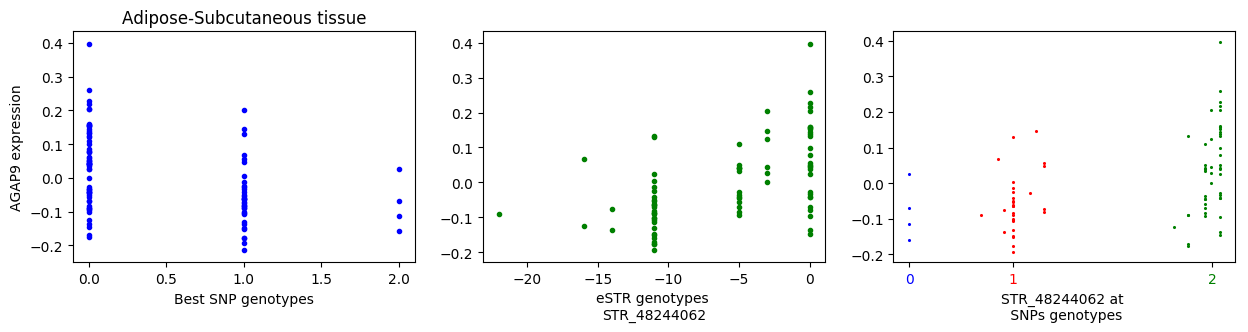


-----> chr21  gene  ENSG00000160213.5 ( CSTB )  Causality Score:  0.941574476131 
Counts by SNP genotypes
2 (6, 3)
1 (47, 3)
0 (74, 3)


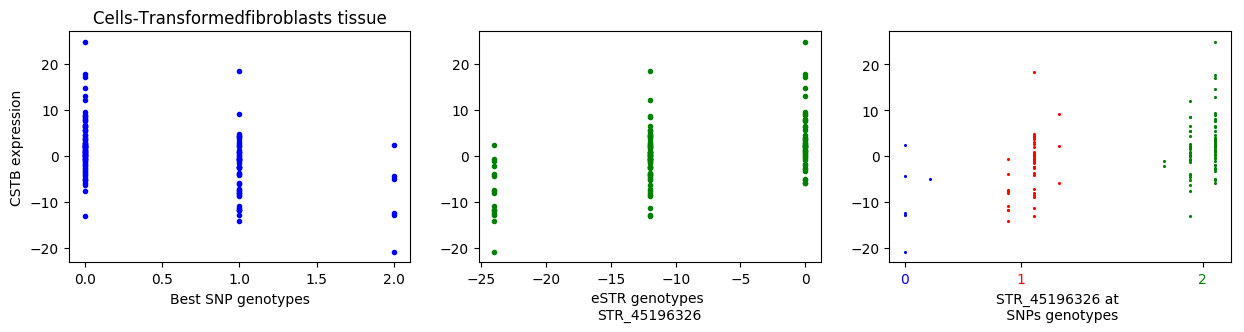


-----> chr17  gene  ENSG00000174282.7 ( ZBTB4 )  Causality Score:  0.94079973531 
Counts by SNP genotypes
2 (8, 3)
1 (29, 3)
0 (69, 3)


ValueError: posx and posy should be finite values


-----> chr14  gene  ENSG00000100852.8 ( ARHGAP5 )  Causality Score:  0.914728681435 
Counts by SNP genotypes
2 (74, 3)
1 (23, 3)
0 (4, 3)


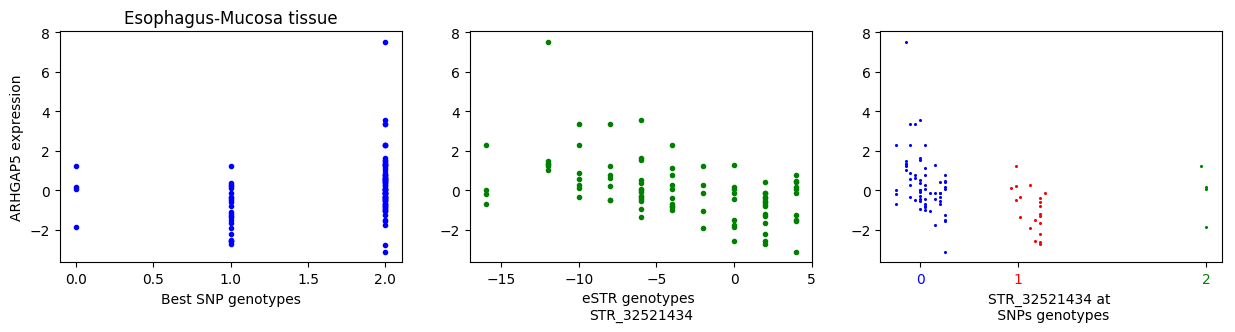


-----> chr2  gene  ENSG00000183023.14 ( SLC8A1 )  Causality Score:  0.91114377439 
Counts by SNP genotypes
1 (16, 3)
0 (85, 3)


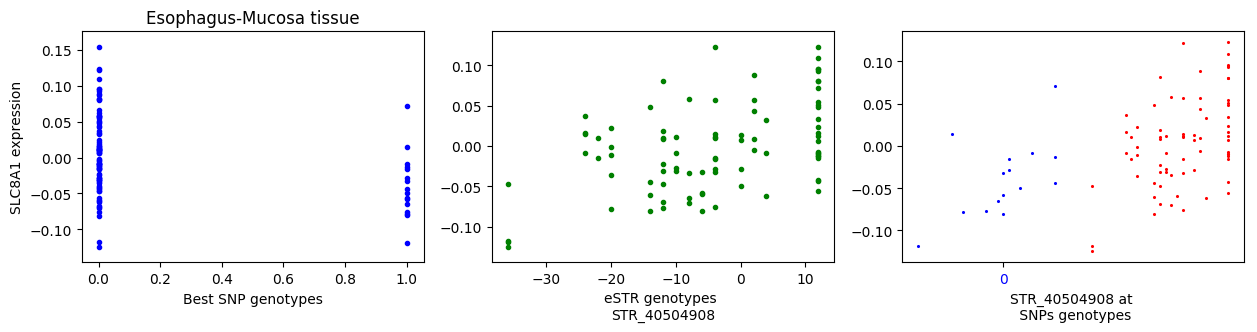


-----> chr10  gene  ENSG00000151640.8 ( DPYSL4 )  Causality Score:  0.877643641219 
Counts by SNP genotypes
2 (67, 3)
1 (49, 3)
0 (11, 3)


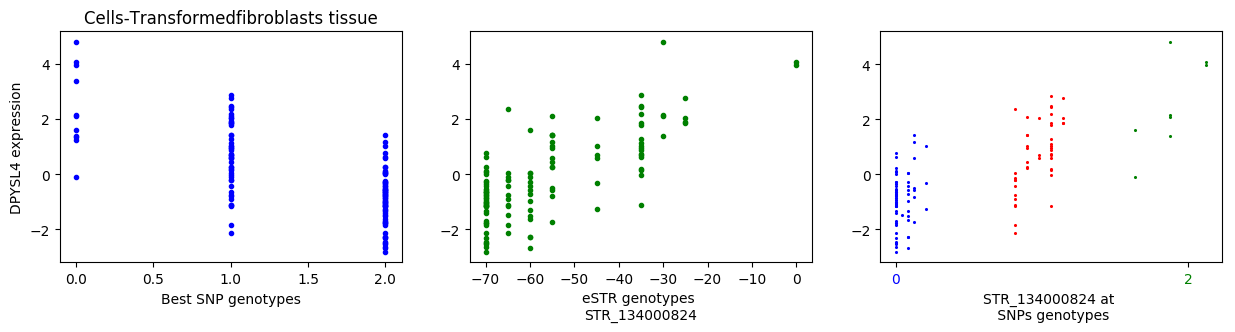


-----> chr1  gene  ENSG00000143434.11 ( SEMA6C )  Causality Score:  0.854704029037 
Counts by SNP genotypes
2 (51, 3)
1 (58, 3)
0 (18, 3)


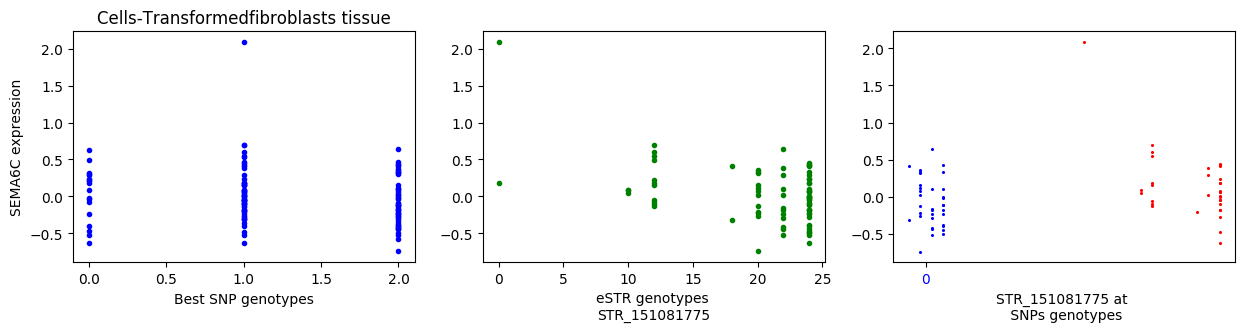


-----> chr11  gene  ENSG00000149489.4 ( ROM1 )  Causality Score:  0.836611617318 
Counts by SNP genotypes
2 (49, 3)
1 (40, 3)
0 (12, 3)


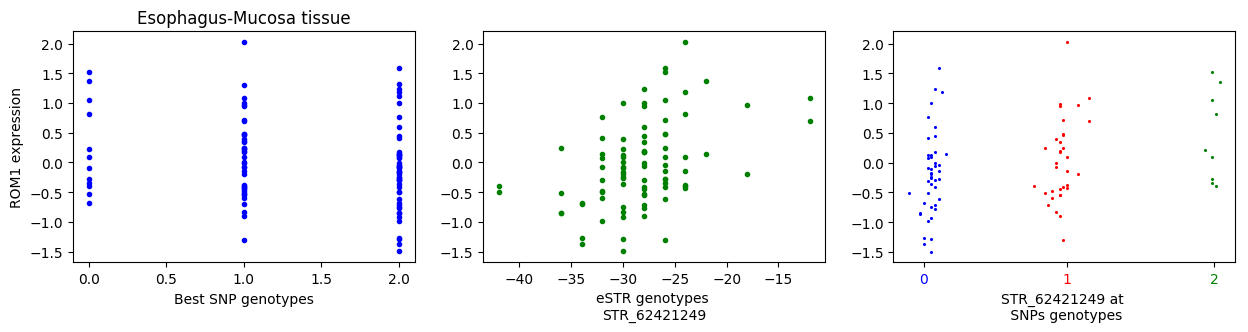


-----> chr9  gene  ENSG00000137103.12 ( TMEM8B )  Causality Score:  0.831290257122 
Counts by SNP genotypes
2 (11, 3)
1 (46, 3)
0 (50, 3)


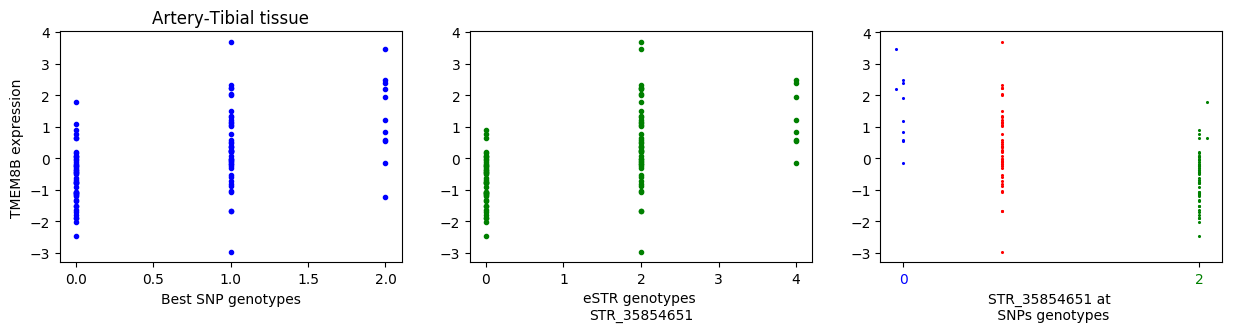


-----> chr8  gene  ENSG00000156831.3 ( NSMCE2 )  Causality Score:  0.826411741571 
Counts by SNP genotypes
2 (8, 3)
1 (47, 3)
3 (1, 3)
0 (45, 3)


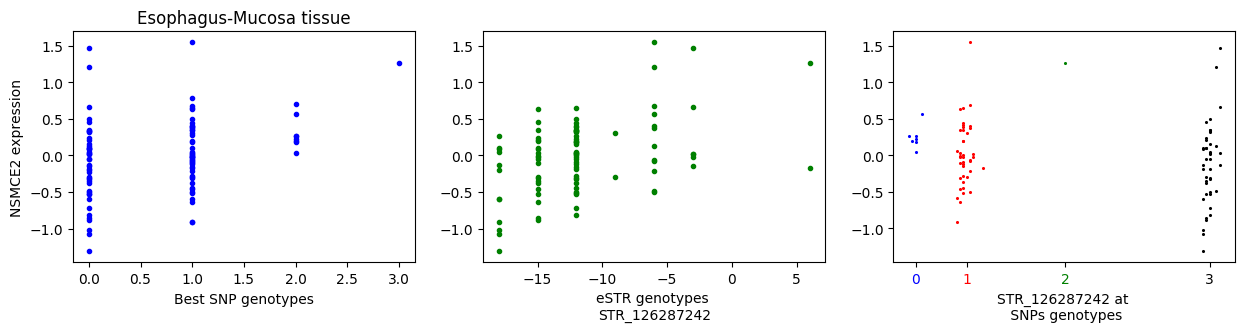


-----> chr1  gene  ENSG00000162733.12 ( DDR2 )  Causality Score:  0.816752391985 
Counts by SNP genotypes
1 (17, 3)
0 (92, 3)


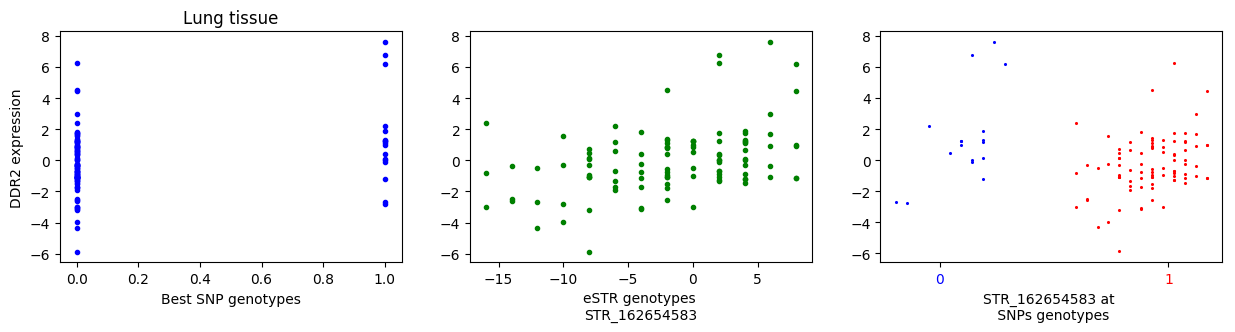

In [4]:
#
# Examples “causal loci”
#
print('\nExamples of Causal loci (eSTRs with high causality score)')
tissues = list(data0['best.tissue'])
genes = list(data0['gene'])
causal_loci=[]
for i in range(len(tissues)):
    D1= pd.read_csv("/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/"+tissues[i]+"/Master.table", sep='\t')
    if list(D1.loc[D1['gene']==genes[i]]['significant'])[0]==1 :
        causal_loci.append(genes[i])

##I'm removing these examples. They don't look easy to interpret  
OUT_list=["ENSG00000188803.10","ENSG00000198286.5","ENSG00000174446.8","ENSG00000174106.2","ENSG00000188803.10"]

for G in causal_loci[:15]:
    if G in OUT_list:
        continue
    else:
        data = Data.loc[Data['gene']==G]
        plotthat(data, BASEDIR)

One negative example: eSTRs with low causality score

-----> chr4  gene  ENSG00000163682.11 ( RPL9 )  Causality Score:  1.49617369756e-14 
Counts by SNP genotypes
2 (69, 3)
1 (56, 3)
0 (18, 3)


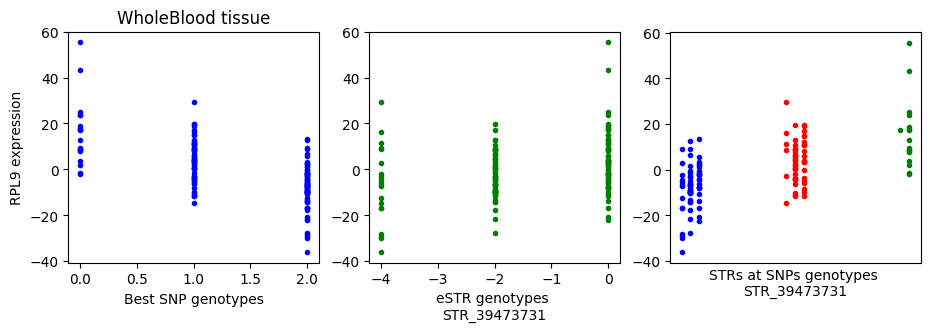

In [4]:
#
#A Negative example
#
print('One negative example: eSTRs with low causality score')
data = Data.loc[(Data['best.score']<0.1) & (Data['best.score']>0)].sort_values('best.score').head(10)
tissues = list(data['best.tissue'])
genes = list(data['gene'])

for i in range(len(tissues)):
    D1= pd.read_csv("/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/"+tissues[i]+"/Master.table", sep='\t')
    if list(D1.loc[D1['gene']==genes[i]]['significant'])[0]==1 :
        Gname=genes[i]  ###Can choose more if Gname is a list
        break
plotthat(Data.loc[Data['gene']==Gname], BASEDIR)

/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Total genes tested  11955 11963 (2537, 4)
(973, 8) (3440, 8) (5244, 8)

NOTE: n=1,2,3,4,5 
 P (Finding an eSTR with  a given motif by chance)== P()

P (A(n)T-rich motif) ~~  7.63028880175 % with OR= 1.13689332235
P (A(n)C-rich motif) ~~  58.9785212895 % with OR= 1.03788319763

 We calculated at eSTRs sites the probability 
 P (For finding an eSTR with a given motif by chance)== P()



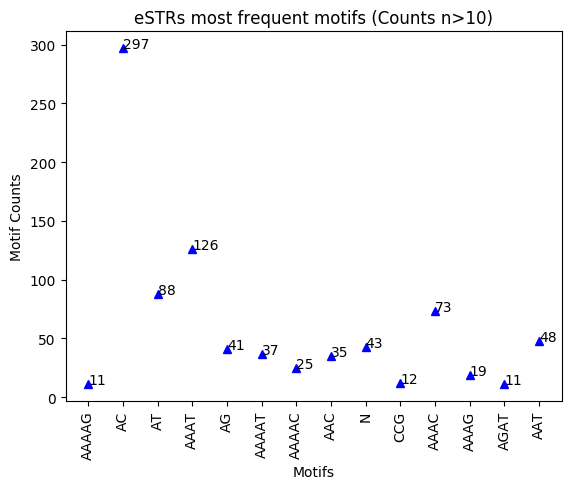

In [6]:
#4.	Enrichment by motif 

tissues = ['WholeBlood','Cells-Transformedfibroblasts','Muscle-Skeletal','Lung','Artery-Tibial','Adipose-Subcutaneous', 'Esophagus-Mucosa']
tissu=tissues[1]
regr='/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/SUMMARY/LR_SummaryTest_Table.tsv'
feat='/storage/szfeupe/Runs/GTEx_estr/FEATURES/Allgencodefeatures_table'
FEAT='/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/SUMMARY/Merged_Causality_Features.tableII'
motif='/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed'

F=[] ; G=[] ; R = []
#open files
R = pd.read_csv(regr, sep='\t')  ; X = R[["gene","chrom","str.start","eSTR_In_tissues"]]
F = pd.read_csv(FEAT, sep='\t')
G = F.merge(X, on =["gene","chrom","str.start"])

# Focus on estrs and motifs
E = G.loc[G['eSTR_In_tissues']>0]
T=list(set(list(E['motif'])))
C=[list(E['motif']).count(x) for x in T]
EM = [[x,list(E['motif']).count(x)] for x in T]
frequent_motifs=[x for x in EM if x[1]>10]
print('Total genes tested ',G.shape[0], F.shape[0], X.loc[X["eSTR_In_tissues"]>0].shape)

data = G[["gene","chrom", "str.start","motif","eSTR_In_tissues","best.score","best.tissue","INTRON"]]
data_e = data.loc[data['eSTR_In_tissues']>0]
AC = ['AAAC', 'AAAAC','AAAAAC', 'AAC', 'AC']
AT = ['AT', 'AAT', 'AAAT', 'AAAAT', 'AAAAAT']
data_eat = data_e.loc[data_e['motif'].isin(AT)]
data_eac = data_e.loc[data_e['motif'].isin(AC)]
data_at = data.loc[data['motif'].isin(AT)]
data_ac = data.loc[data['motif'].isin(AC)]
print(data_e.shape, data_at.shape, data_ac.shape)
CTT_at=[[data_eat.shape[0],data_e.shape[0]- data_eat.shape[0]],[data_at.shape[0]-data_eat.shape[0], data.shape[0]-data_e.shape[0]-(data_at.shape[0]-data_eat.shape[0])]]
CTT_ac=[[data_eac.shape[0],data_e.shape[0]- data_eac.shape[0]],[data_ac.shape[0]-data_eac.shape[0], data.shape[0]-data_e.shape[0]-(data_ac.shape[0]-data_eac.shape[0])]]
od_ac, pvc = ss.fisher_exact([CTT_ac[0], CTT_ac[1]])
od_at, pvt = ss.fisher_exact([CTT_at[0], CTT_at[1]])
print('\nNOTE: n=1,2,3,4,5 \n P (Finding an eSTR with  a given motif by chance)== P()\n')
print ("P (A(n)T-rich motif) ~~ ",pvt*100,"% with OR=", od_at)
print ("P (A(n)C-rich motif) ~~ ",pvc*100,"% with OR=", od_ac)
           
#frequent_motifs
Motifs = list(set(list(data_e['motif'])))
Mo_counts=[list(data['motif']).count(x) for x in Motifs]
Estr = data_e.shape[0]
Str = data.shape[0]
FMotifs = [x[0] for x in frequent_motifs]
sig_motifs=[]
All = []
print('\n We calculated at eSTRs sites the probability \n P (For finding an eSTR with a given motif by chance)== P()\n')
for M in Motifs:
    data_eM = data_e.loc[data_e['motif']==M]
    data_M = data.loc[data['motif']==M]
    Mestrs = data_eM.shape[0]
    Mstrs = data_M.shape[0]
    CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
    oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])
####print ("P (", M, ")    ~~   ",pv*100,"%     with    OR=", oddsratio)
    All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
    if pv<=0.05:
        sig_motifs.append([M,pv*100,oddsratio])
    
plt.plot([x[1] for x in frequent_motifs],'b^')
plt.xlabel('Motifs')
plt.ylabel('Motif Counts')
plt.title('eSTRs most frequent motifs (Counts n>10)')
plt.xticks([x for x in range(len([x[1] for x in frequent_motifs]))],[x[0] for x in frequent_motifs], rotation='vertical')

num = [str(x[1]) for x in frequent_motifs]

for i, N in enumerate(num):
    plt.annotate(N, ([x for x in range(len(num))][i],[x[1] for x in frequent_motifs][i]))

plt.show()
#plt.savefig("motifsE.png")   



Chances of causal STR (eSTR + high causal score) is  0.08138854035968214
Chances for an eSTR to be an AC-rich:  0.447070914696814
Chances of STR to be AC-rich + non-eSTR:  0.9170480549199085
Likelihood ratio of an'AC-rich' eSTR is  0.48751089138492254


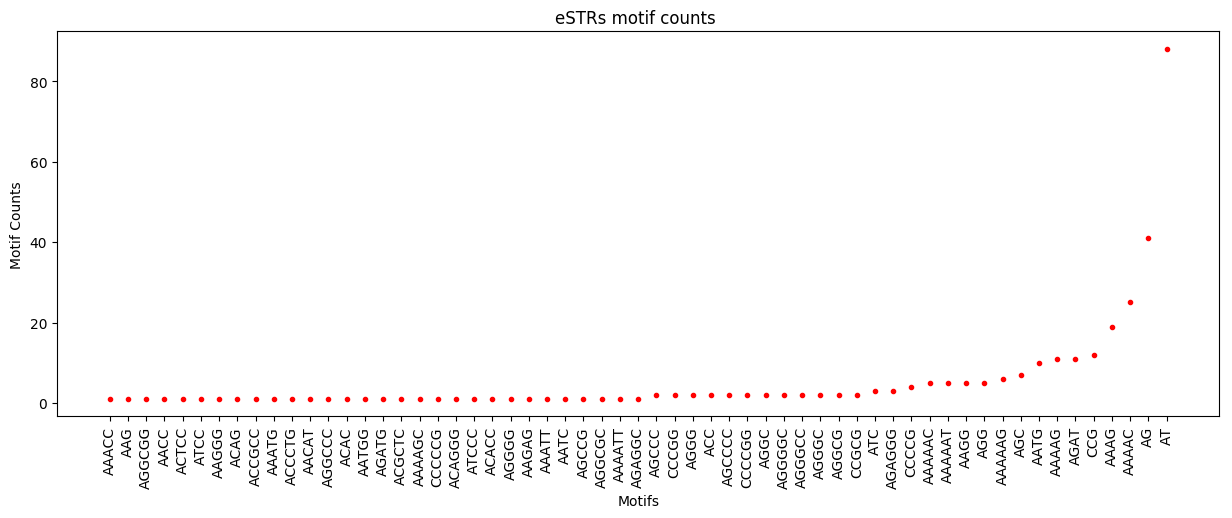

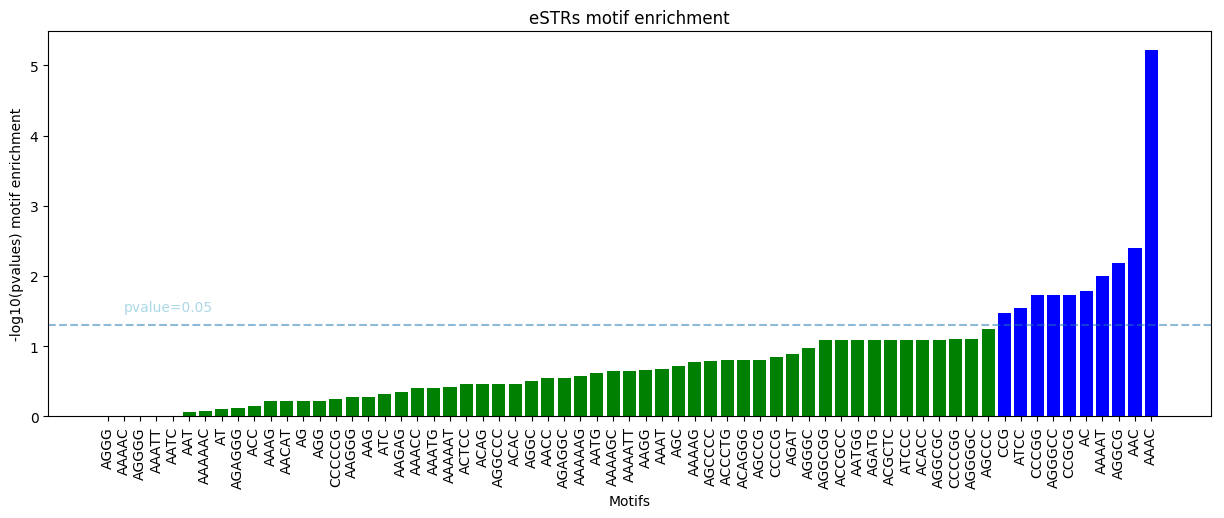

In [7]:
# We calculate at eSTRs sites the probability 
#P (For finding an eSTR with a given motif by chance)== P()) [Fisher test]
sig_motifs=[]
All = []
for M in Motifs:
    data_eM = data_e.loc[data_e['motif']==M]
    data_M = data.loc[data['motif']==M]
    Mestrs = data_eM.shape[0]
    Mstrs = data_M.shape[0]
    CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
    oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])
#   print ("P (", M, ")    ~~   ",pv*100,"%     with    OR=", oddsratio)
    All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
    if pv<=0.05:
        sig_motifs.append([M,pv*100,oddsratio])
    
p=Estr/data.shape[0]
print("Chances of causal STR (eSTR + high causal score) is ", p)
print ("Chances for an eSTR to be an AC-rich: ", data_eac.shape[0]/data_e.shape[0])
print("Chances of STR to be AC-rich + non-eSTR: ",(data_ac.shape[0]-data_eac.shape[0])/(data_ac.shape[0]))     
print("Likelihood ratio of an'AC-rich' eSTR is ",(data_eac.shape[0]/data_e.shape[0])/((data_ac.shape[0]-data_eac.shape[0])/(data_ac.shape[0])) )

count_uniq_mo = sorted(list(set(Mo_counts)))
ordered_All = []
for u in count_uniq_mo:
    ordered_All=ordered_All + [x for x in All if x[1]==u]

plt.figure(figsize=(15,3))
#plt.hist([x for x in range(len(ordered_All))] , [x[1] for x in ordered_All] , color='orange')
plt.plot([x[1] for x in ordered_All],'r.')
plt.xlabel('Motifs')
plt.ylabel('Motif Counts')
plt.title('eSTRs motif counts ')
plt.xticks([x for x in range(len(ordered_All))],[x[0] for x in ordered_All], rotation='vertical')
plt.show()

count_uniq_mo = sorted(list(set([x[2] for x in All])))
ordered_All = []
for u in count_uniq_mo:
    ordered_All=ordered_All + [x for x in All if x[2]==u]

plt.figure(figsize=(15,5))
Y=[x[2] for x in ordered_All]
X=[x for x in range(len(ordered_All))]
Y = Y[:-1] ; X = X[:-1]
col = ['b' if x>-np.log10(0.05) else 'g' for x in Y ]

#plt.scatter(X, Y, c=col, s=20, linewidth=1)
plt.bar(X, Y, color=col)
plt.xlabel('Motifs')
plt.ylabel('-log10(pvalues) motif enrichment')
plt.title('eSTRs motif enrichment')
plt.xticks(X,[x[0] for x in ordered_All], rotation='vertical')
plt.axhline(y=-np.log10(0.05), xmin=0, xmax=1, hold=None, alpha=0.5, ls='--')
plt.text(1, 1.5, 'pvalue=0.05', color='lightblue')

plt.show()



In [ ]:
#3.	Enrichment as a function of distance to TSS, TES, nearest splice site  
# See Figure2'